In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.wandb_client import get_run_result
from thesispy.experiments.validation import *
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.stats import ttest_ind


In [2]:
ds = get_runs_as_dataset("synthetic_1_fair_comparison")

# for run in ds.runs:
#     run.resolutions[0] = run.resolutions[0].rename(columns={"2a:metric": "metric"})
#     run.summary = run.summary.rename({"2a:metric": "metric"})

# ds.save()

arrs = ds.aggregate_for_plot(["Optimizer", "MeshSize"])

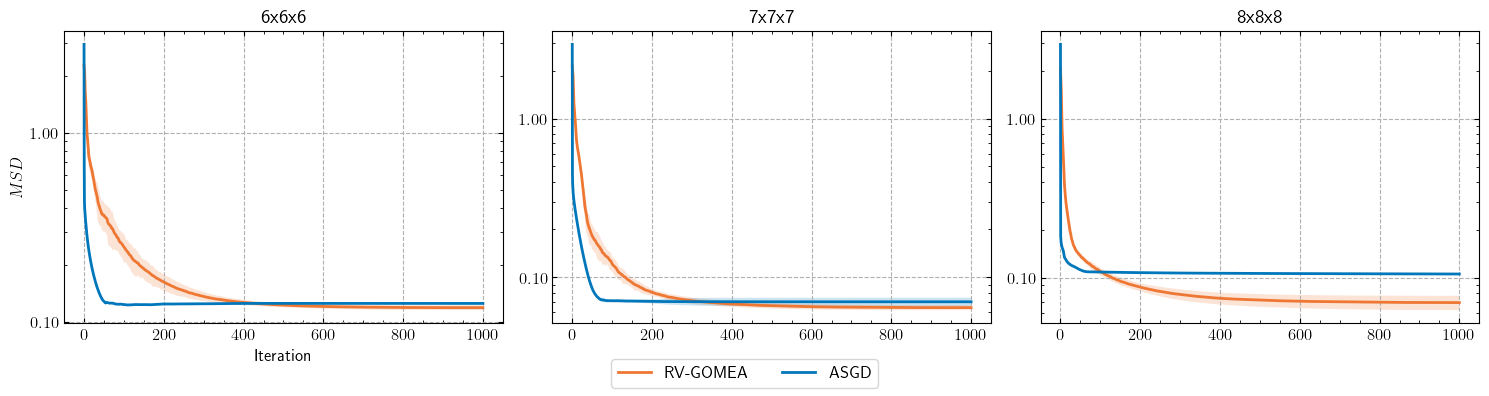

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    for i, mesh_size in enumerate([(3, 3, 3), (4, 4, 4), (5, 5, 5)]):
        arr_avg, arr_median, arr_std = arrs[(optimizer, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_avg))
        label = "RV-GOMEA" if optimizer == "GOMEA" else "ASGD"
        axes[i].plot(xs, arr_avg, label=label)
        axes[i].fill_between(xs, arr_avg - arr_std, arr_avg + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(formatter)
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)


axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower center", prop={'size': 12})

plt.tight_layout(rect=[0, 0.04, 1, 1])
# plt.savefig("fair_comparison.pdf")

In [33]:
from thesispy.experiments.validation import *
from thesispy.experiments.wandb_client import get_run_result

# for run in ds.runs:
#     if len(run.summary.index) <= 19:
#         continue
#     indices = ["tre", "mean_surface_cube", "mean_surface_sphere", "bending_energy", "dvf_rmse", "dice_sphere"]
#     result = get_run_result(ds.project, run.id)
#     mean_surface_dists = mean_surface_distance(result.instance.surface_points, result.deformed_surface_points)
#     dices = dice_similarity(result.deformed, result.instance.fixed, 3)
#     dvf_copy = np.copy(result.dvf)
#     mask = np.linalg.norm(result.instance.dvf, axis=-1) > 0
#     dvf_copy[~mask] = np.array([0 for _ in range(dvf_copy.shape[-1])])

#     new_values = {
#         "tre": tre(result.deformed_lms, result.instance.lms_moving, result.instance.spacing),
#         "mean_surface_cube": mean_surface_dists[0],
#         "mean_surface_sphere": mean_surface_dists[1],
#         "bending_energy": bending_energy(dvf_copy),
#         "dvf_rmse": dvf_rmse(dvf_copy, result.instance.dvf),
#         "dice_sphere": dices[1]
#     }
#     values = new_values.values()

#     run.summary = run.summary.drop(indices)
#     run.summary = run.summary.append(pd.Series(values, index=indices))

# ds.save()

2023-01-27 17:37:05,552 - Validation - INFO - Mean Surface Distances: [0.45945030800049763, 0.3146876385799189]
2023-01-27 17:37:05,555 - Validation - INFO - Dice Similarities: [0.9961680672268908, 0.9493333333333334]
2023-01-27 17:37:05,557 - Validation - INFO - TRE: 1.0833175953171341
computing bending energy: 100%|██████████| 13824/13824 [00:07<00:00, 1885.79it/s]
2023-01-27 17:37:12,892 - Validation - INFO - Bending Energy: 0.18755195546659365
2023-01-27 17:37:12,894 - Validation - INFO - DVF RMSE: 0.7614147723937627
/tmp/ipykernel_156531/1145650506.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run.summary = run.summary.append(pd.Series(values, index=indices))
2023-01-27 17:37:15,330 - Validation - INFO - Mean Surface Distances: [0.5551261019324044, 0.28057160616557014]
2023-01-27 17:37:15,334 - Validation - INFO - Dice Similarities: [0.9985893732786996, 0.9811320754716981]
2023-01-27 1

In [4]:
df = ds.aggregate(["Optimizer", "MeshSize"], metrics=VALIDATION_NAMES_NEW, val=True)

In [6]:
from tabulate import tabulate

rows = []

for i, metric in enumerate(VALIDATION_NAMES_NEW):
    row = []
    row.append(VALIDATION_ABBRVS_NEW[i])
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")][metric]
        avg_gomea = df_gomea.mean()
        std_gomea = df_gomea.std()

        df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")][metric]
        avg_asgd = df_asgd.mean()
        std_asgd = df_asgd.std()
        
        gomea_better = avg_gomea < avg_asgd if metric != "dice_sphere" else avg_gomea > avg_asgd
        t_test = ttest_ind(df_gomea, df_asgd, equal_var=False)
        
        if t_test.pvalue >= 0.05:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
            continue

        if gomea_better:
            row.append(f"\\textbf{{{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
        else:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"\\textbf{{{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}}}")

    rows.append(row)

print(tabulate(rows, headers=["RV-GOMEA", "ASGD"]*3, tablefmt="latex_raw"))

\begin{tabular}{lllllll}
\hline
                         & RV-GOMEA                      & ASGD                          & RV-GOMEA                      & ASGD                          & RV-GOMEA                      & ASGD                          \\
\hline
 $TRE$                   & \textbf{0.73 ± \num{1.1e-01}} & 1.04 ± \num{1.6e-03}          & 2.10 ± \num{2.8e-01}          & \textbf{0.84 ± \num{1.5e-01}} & 1.97 ± \num{1.5e-01}          & \textbf{1.08 ± \num{2.3e-03}} \\
 $ASD_{\textsc{cube}}$   & \textbf{0.39 ± \num{7.1e-03}} & 0.52 ± \num{4.8e-04}          & 0.43 ± \num{1.4e-02}          & \textbf{0.36 ± \num{7.3e-03}} & 0.57 ± \num{2.1e-02}          & \textbf{0.46 ± \num{2.0e-03}} \\
 $ASD_{\textsc{sphere}}$ & 0.31 ± \num{9.2e-03}          & 0.31 ± \num{4.2e-05}          & 0.28 ± \num{1.3e-02}          & \textbf{0.26 ± \num{1.4e-02}} & \textbf{0.28 ± \num{6.1e-03}} & 0.31 ± \num{5.6e-05}          \\
 $DSC_{\textsc{sphere}}$ & 0.92 ± \num{3.2e-03}          & \textbf{0.94 ± \num{2.

/tmp/ipykernel_198283/3965318026.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test = ttest_ind(df_gomea, df_asgd, equal_var=False)


In [ ]:
ttest_results = []
df = ds.aggregate(["Optimizer", "MeshSize"], val=True)

for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
    df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")]["metric"].values
    df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")]["metric"].values
    ttest_results.append(ttest_ind(df_gomea, df_asgd, equal_var=False))
    print(df_gomea.mean(), df_asgd.mean())
    print(df_gomea.std(), df_asgd.std())

print(ttest_results)

In [2]:
asgd_8 = get_run_result("synthetic_1_fair_comparison", "2oab4luv")
gomea_8 = get_run_result("synthetic_1_fair_comparison", "2qurpss2")

In [3]:
from thesispy.experiments.validation import validation_visualization, get_vmin_vmax

dvf_clim, jac_clim = get_vmin_vmax(asgd_8, gomea_8)

2023-03-16 12:52:57,011 - Validation - INFO - Jacobian min,max: -0.15004246407549815, 7.755897659747731
2023-03-16 12:52:57,014 - Validation - INFO - Jacobian min,max: -5.89749386157173, 13.047944229460867


In [6]:
asgd_figs = validation_visualization(asgd_8, dvf_clim, jac_clim, tre=False)
plt.savefig("nomr_gresult_asgd8.pdf", bbox_inches="tight")

2023-03-16 12:53:15,077 - Validation - INFO - Jacobian min,max: -0.15004246407549815, 7.755897659747731


In [7]:
gomea_figs = validation_visualization(gomea_8, dvf_clim, jac_clim, tre=False)
plt.savefig("nomr_gresult_gomea8.pdf", bbox_inches="tight")

2023-03-16 12:53:17,495 - Validation - INFO - Jacobian min,max: -5.89749386157173, 13.047944229460867
